# **Importing Necessary Modules**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
!pip install emoji
import emoji
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping
from transformers import EarlyStoppingCallback
!pip install optuna
import optuna
import pickle
from sklearn.metrics import confusion_matrix, classification_report
!pip install transformers datasets
import json
from datasets import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments, EvalPrediction
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 27.9 MB/s eta 0:00:00


[nltk_data] Downloading package wordnet to /root/nltk_data...


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.9 MB/s eta 0:00:00


# **Loading the Dataset**

In [3]:
df = pd.read_csv('/content/Deepseek Reviews Analysis.csv')
df.head()

,Unnamed: 0,content,score,thumbsUpCount,at
0,0,"It's Great app, but an organization feature wo...",5,54,2025-01-29 16:05:38
1,1,DeepSeek is an absolute game-changer! This app...,5,38,2025-01-28 19:34:25
2,2,I hope this message finds you well. I’m a big ...,5,45,2025-02-01 10:55:53
3,3,Subject: Issue with App Performance – Server B...,1,365,2025-02-01 17:58:11
4,4,DeepSeek is a game-changer! Its AI-powered sea...,5,10,2025-02-01 17:01:23


# **Dropping Irrelevant Features**

In [4]:
df = df.drop(columns = ['Unnamed: 0', 'thumbsUpCount', 'at'], axis = 1)

# **Exploratory Data Analysis**

# **Heatmap To Visualize the Missing Values**

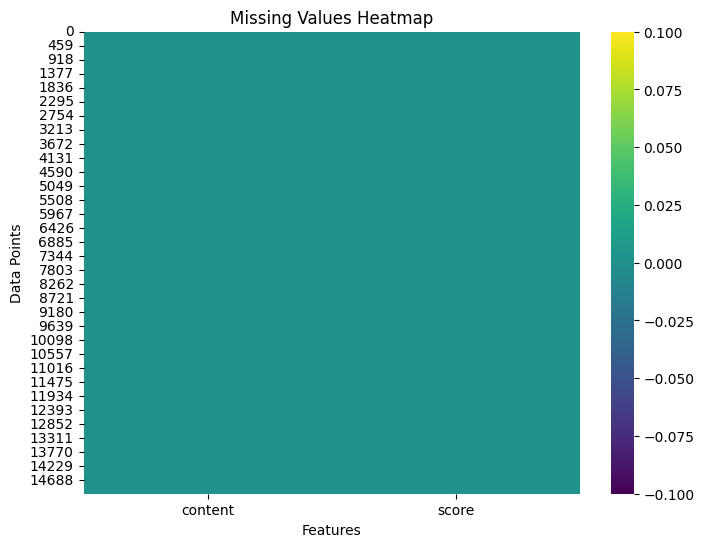

In [5]:
missing_values = df.isnull()

# Plotting missing values heatmap
plt.figure(figsize = (8, 6))
sns.heatmap(missing_values, cmap = 'viridis', cbar = True)
plt.title('Missing Values Heatmap')
plt.xlabel('Features')
plt.ylabel('Data Points')
plt.show()

# **Plotting the Distribution of Labels**

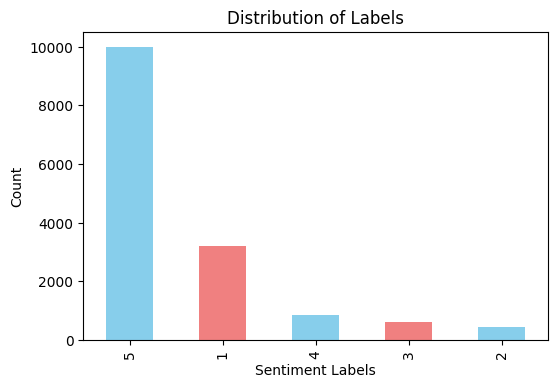

score
5    10009
1     3197
4      842
3      622
2      454
Name: count, dtype: int64


In [6]:
plt.figure(figsize = (6, 4))
df['score'].value_counts().plot(kind = 'bar', color = ['skyblue', 'lightcoral'])
plt.title('Distribution of Labels')
plt.xlabel('Sentiment Labels')
plt.ylabel('Count')
plt.show()

print(df['score'].value_counts())

# **Merging the Scores 5, 4 and 3 into 1 (positive) & 2, 1 into 0 (negative) Class**

In [7]:
df['score'] = df['score'].apply(lambda x: 1 if x in [3, 4, 5] else 0)

# **Plotting the Updated Distribution of Labels**

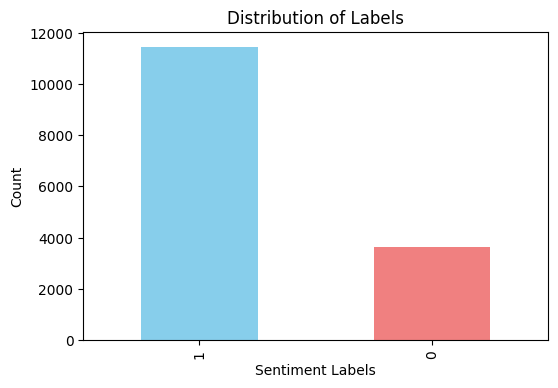

In [8]:
plt.figure(figsize = (6, 4))
df['score'].value_counts().plot(kind = 'bar', color = ['skyblue', 'lightcoral'])
plt.title('Distribution of Labels')
plt.xlabel('Sentiment Labels')
plt.ylabel('Count')
plt.show()

# **Pie Chart for Proportions**

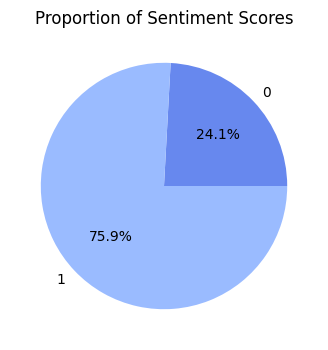

In [9]:
score_counts = df['score'].value_counts().sort_index()
plt.figure(figsize=(4, 4))
plt.pie(score_counts, labels=score_counts.index, autopct='%1.1f%%', colors=sns.color_palette('coolwarm'))
plt.title('Proportion of Sentiment Scores')
plt.show()

**We can see that there is class imbalance which needs to be fixed**

# **Data Pre-Processing**

# **Converting the 'Text' Column to Lowercase**

In [10]:
df['content'] = df['content'].str.lower()
df.head()

,content,score
0,"it's great app, but an organization feature wo...",1
1,deepseek is an absolute game-changer! this app...,1
2,i hope this message finds you well. i’m a big ...,1
3,subject: issue with app performance – server b...,0
4,deepseek is a game-changer! its ai-powered sea...,1


# **Removing the HTML Tags (If Any)**

In [11]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

# Removing HTML tags from 'content' column
df['content'] = df['content'].apply(remove_html_tags)

# **Removing URLs (If Any)**

In [12]:
def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)

# Applying the function to the 'content' column
df['content'] = df['content'].apply(remove_urls)

# **Remove Punctuations**

In [13]:
# Defining the punctuation characters to remove
punctuation = string.punctuation

# Function to remove punctuation from text
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punctuation))

# Applying the remove_punctuation function to 'content' column
df['content'] = df['content'].apply(remove_punctuation)

# **Handling ChatWords**

In [14]:
# Defining a dictionary of chat word mappings
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}
# Function to replace chat words with their full forms
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)

# Applying replace_chat_words function to 'content' column
df['content'] = df['content'].apply(replace_chat_words)

# **Handling StopWords**

In [15]:
# Getting the English stopwords from NLTK
stop_words = set(stopwords.words('english'))

# Function to remove stop words from text
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Applying remove_stopwords function to 'content' column
df['content'] = df['content'].apply(remove_stopwords)

# **Handling Emojies**

In [16]:
# Function to remove emojis from text
def remove_emojis(text):
    return emoji.demojize(text)

# Applying remove_emojis function to 'content' column
df['content'] = df['content'].apply(remove_emojis)

# **Applying Lemmatization**

In [17]:
# Intilizing the lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Applying the lemmatizer
df['content'] = df['content'].apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(word , pos='v') for word in x.split()]))

# **Applying the Train Test Split**

In [18]:
X = df['content']
y = df['score']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape is : ", X_train.shape)
print("X_test shape is : ", X_test.shape)
print("y_train shape is : ", y_train.shape)
print("y_test shape is : ", y_test.shape)

X_train shape is :  (12099,)
X_test shape is :  (3025,)
y_train shape is :  (12099,)
y_test shape is :  (3025,)


# **Performing the Tokenization**

In [19]:
tokenizer = Tokenizer(oov_token='nothing')
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# **Plotting a Boxplot to Find the Good Value For Maximum Sequence Length**

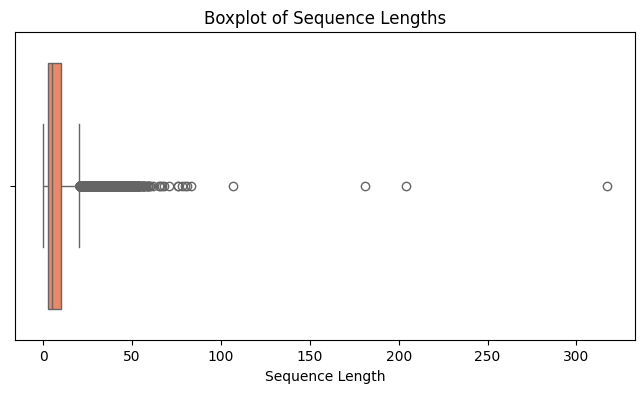

In [20]:
seq_lengths = [len(seq) for seq in X_train_sequences]

# Plotting the boxplot
plt.figure(figsize = (8, 4))
sns.boxplot(x=seq_lengths , color  = 'coral')
plt.title("Boxplot of Sequence Lengths")
plt.xlabel("Sequence Length")
plt.show()

**By looking at the boxplot we can see that there are some extreme outliers too, but we'll keep the maxlen = 90 as it is handling majority of the outliers.**

# **Applying Padding**

In [21]:
# Padding the sequences to ensure uniform length
maxlen = 90
X_train_padded = pad_sequences(X_train_sequences, maxlen = maxlen, padding='pre')
X_test_padded = pad_sequences(X_test_sequences, maxlen = maxlen, padding='pre')

# **Computing the Class Weights to Handle Imbalance**

In [22]:
y_train_array = y_train.values if isinstance(y_train, pd.Series) else y_train
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_array), y=y_train_array)
class_weights = {i: weight for i, weight in zip(np.unique(y_train_array), weights)}

print("Class weights:", class_weights)

Class weights: {0: 2.089637305699482, 1: 0.6572685788787483}


**We can see that the weight for class 0 (negative) is higher because it is the minority class, while class 1 (positive) is more prevalent. This inverse weighting helps balance the impact of each class during training**

# **Model Building: BiLSTM**

# **Hyperparameter Tuning with Optuna For BiLSTM with Early Stopping**

In [22]:
def objective(trial):
    # Suggested hyperparameters
    embedding_dim = trial.suggest_categorical('embedding_dim', [32, 64, 128, 256])
    lstm_units = trial.suggest_int('lstm_units', 16, 128, step=32)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    # Building the Bidirectional LSTM model
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                        output_dim=embedding_dim,
                        input_length=maxlen))
    model.add(Bidirectional(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate)))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

    # Training the model with a validation split and early stopping
    history = model.fit(X_train_padded, y_train,
                        epochs=20,
                        batch_size=batch_size,
                        validation_split=0.2,
                        callbacks=[early_stop],
                        class_weight=class_weights,
                        verbose=1)

    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy

# Creating and running the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

print("Best trial:")
trial = study.best_trial
print("  Best Validation Accuracy: {:.4f}".format(trial.value))
print("  Best Hyperparameters:")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-02-24 08:48:33,658] A new study created in memory with name: no-name-f3c6e992-1c1b-45ec-a73c-d181f520dee1


Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 180s 538ms/step - accuracy: 0.7566 - loss: 0.5490 - val_accuracy: 0.8769 - val_loss: 0.3113
Epoch 2/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 164s 541ms/step - accuracy: 0.9004 - loss: 0.2728 - val_accuracy: 0.8789 - val_loss: 0.3132
Epoch 3/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 202s 542ms/step - accuracy: 0.9253 - loss: 0.2136 - val_accuracy: 0.8764 - val_loss: 0.3141
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 201s 540ms/step - accuracy: 0.9396 - loss: 0.1756 - val_accuracy: 0.8727 - val_loss: 0.3345
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


[I 2025-02-24 09:01:40,635] Trial 0 finished with value: 0.8727272748947144 and parameters: {'embedding_dim': 32, 'lstm_units': 80, 'dropout_rate': 0.2, 'learning_rate': 0.0012460568127165643, 'batch_size': 32}. Best is trial 0 with value: 0.8727272748947144.


Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 91s 552ms/step - accuracy: 0.7553 - loss: 0.5193 - val_accuracy: 0.8810 - val_loss: 0.2905
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 141s 548ms/step - accuracy: 0.9109 - loss: 0.2403 - val_accuracy: 0.8802 - val_loss: 0.3067
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 141s 542ms/step - accuracy: 0.9393 - loss: 0.1819 - val_accuracy: 0.8798 - val_loss: 0.3035
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 84s 553ms/step - accuracy: 0.9496 - loss: 0.1514 - val_accuracy: 0.8764 - val_loss: 0.3545
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


[I 2025-02-24 09:10:15,696] Trial 1 finished with value: 0.8764463067054749 and parameters: {'embedding_dim': 256, 'lstm_units': 48, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0015043377864092738, 'batch_size': 64}. Best is trial 1 with value: 0.8764463067054749.


Epoch 1/20
605/605 ━━━━━━━━━━━━━━━━━━━━ 336s 544ms/step - accuracy: 0.7925 - loss: 0.4412 - val_accuracy: 0.8798 - val_loss: 0.3017
Epoch 2/20
605/605 ━━━━━━━━━━━━━━━━━━━━ 382s 545ms/step - accuracy: 0.9183 - loss: 0.2090 - val_accuracy: 0.8715 - val_loss: 0.3337
Epoch 3/20
605/605 ━━━━━━━━━━━━━━━━━━━━ 324s 534ms/step - accuracy: 0.9509 - loss: 0.1356 - val_accuracy: 0.8802 - val_loss: 0.3261
Epoch 4/20
605/605 ━━━━━━━━━━━━━━━━━━━━ 386s 542ms/step - accuracy: 0.9590 - loss: 0.1156 - val_accuracy: 0.8715 - val_loss: 0.3804
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


[I 2025-02-24 09:34:57,833] Trial 2 finished with value: 0.8714876174926758 and parameters: {'embedding_dim': 128, 'lstm_units': 112, 'dropout_rate': 0.2, 'learning_rate': 0.004598912800387605, 'batch_size': 16}. Best is trial 1 with value: 0.8764463067054749.


Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 89s 542ms/step - accuracy: 0.7631 - loss: 0.4885 - val_accuracy: 0.8612 - val_loss: 0.3490
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 141s 534ms/step - accuracy: 0.9145 - loss: 0.2474 - val_accuracy: 0.8781 - val_loss: 0.3059
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 83s 545ms/step - accuracy: 0.9367 - loss: 0.1742 - val_accuracy: 0.8826 - val_loss: 0.3126
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 142s 549ms/step - accuracy: 0.9553 - loss: 0.1313 - val_accuracy: 0.8686 - val_loss: 0.3452
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 142s 549ms/step - accuracy: 0.9548 - loss: 0.1337 - val_accuracy: 0.8645 - val_loss: 0.3576
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


[I 2025-02-24 09:44:55,027] Trial 3 finished with value: 0.8644627928733826 and parameters: {'embedding_dim': 128, 'lstm_units': 48, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0029201232110142, 'batch_size': 64}. Best is trial 1 with value: 0.8764463067054749.


Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 92s 557ms/step - accuracy: 0.7987 - loss: 0.4679 - val_accuracy: 0.8674 - val_loss: 0.3509
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 140s 544ms/step - accuracy: 0.9178 - loss: 0.2328 - val_accuracy: 0.8839 - val_loss: 0.2908
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 144s 562ms/step - accuracy: 0.9370 - loss: 0.1694 - val_accuracy: 0.8806 - val_loss: 0.3276
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 140s 549ms/step - accuracy: 0.9451 - loss: 0.1445 - val_accuracy: 0.8831 - val_loss: 0.3678
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 143s 553ms/step - accuracy: 0.9552 - loss: 0.1173 - val_accuracy: 0.8864 - val_loss: 0.3366
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


[I 2025-02-24 09:55:54,436] Trial 4 finished with value: 0.8863636255264282 and parameters: {'embedding_dim': 256, 'lstm_units': 80, 'dropout_rate': 0.2, 'learning_rate': 0.0024186523321013845, 'batch_size': 64}. Best is trial 4 with value: 0.8863636255264282.


Best trial:
  Best Validation Accuracy: 0.8864
  Best Hyperparameters:
    embedding_dim: 256
    lstm_units: 80
    dropout_rate: 0.2
    learning_rate: 0.0024186523321013845
    batch_size: 64


# **Training the Final Model with Best Hyperparameters and Early Stopping**

In [23]:
best_params = trial.params

final_model = Sequential()
final_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                          output_dim=best_params['embedding_dim'],
                          input_length=maxlen))
final_model.add(Bidirectional(LSTM(best_params['lstm_units'],
                                   dropout=best_params['dropout_rate'],
                                   recurrent_dropout=best_params['dropout_rate'])))
final_model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
final_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

final_history = final_model.fit(X_train_padded, y_train,
                                epochs=20,
                                batch_size=best_params['batch_size'],
                                validation_split=0.2,
                                callbacks=[early_stop],
                                class_weight=class_weights,
                                verbose=1)

Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 99s 565ms/step - accuracy: 0.7925 - loss: 0.4783 - val_accuracy: 0.8868 - val_loss: 0.3053
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 139s 550ms/step - accuracy: 0.9216 - loss: 0.2320 - val_accuracy: 0.8888 - val_loss: 0.2925
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 142s 550ms/step - accuracy: 0.9403 - loss: 0.1706 - val_accuracy: 0.8806 - val_loss: 0.3174
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 83s 544ms/step - accuracy: 0.9552 - loss: 0.1314 - val_accuracy: 0.8777 - val_loss: 0.3254
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 151s 603ms/step - accuracy: 0.9614 - loss: 0.1061 - val_accuracy: 0.8702 - val_loss: 0.3935
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


# **Plotting the Training & Validation Results**

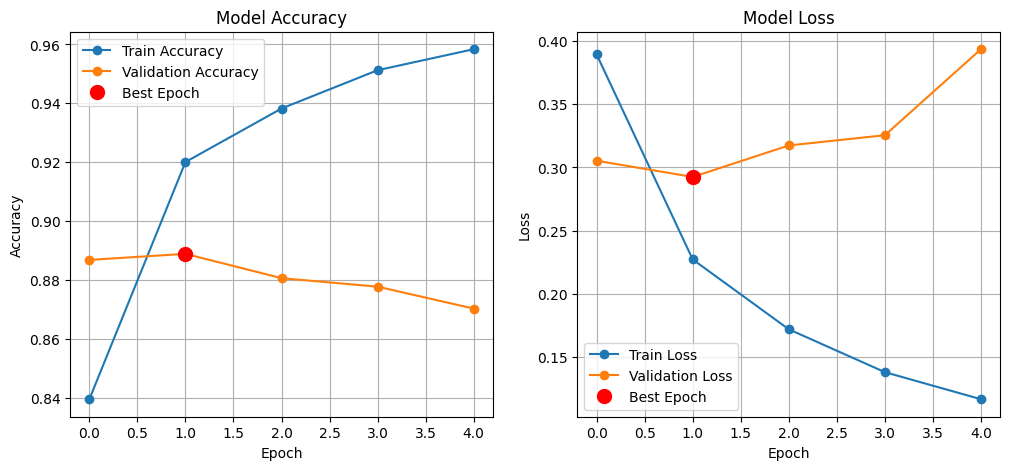

In [33]:
# Identifying the best epoch based on validation loss
best_epoch = np.argmin(final_history.history['val_loss']) + 1
best_epoch_idx = best_epoch - 1


# Plotting all training/validation curves
plt.figure(figsize=(12, 5))

# Accuracy Subplot
plt.subplot(1, 2, 1)
plt.plot(final_history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(final_history.history['val_accuracy'], marker='o', label='Validation Accuracy')

# Highlighting the best epoch in validation accuracy
best_val_acc = final_history.history['val_accuracy'][best_epoch_idx]
plt.plot(best_epoch_idx, best_val_acc, 'ro', markersize=10, label='Best Epoch')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Subplot
plt.subplot(1, 2, 2)
plt.plot(final_history.history['loss'], marker='o', label='Train Loss')
plt.plot(final_history.history['val_loss'], marker='o', label='Validation Loss')

# Highlighting the best epoch in validation loss
best_val_loss = final_history.history['val_loss'][best_epoch_idx]
plt.plot(best_epoch_idx, best_val_loss, 'ro', markersize=10, label='Best Epoch')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# **Saving the History Using Pickle**

In [26]:
with open('BiLSTM_model_history.pkl', 'wb') as f:
    pickle.dump(final_history.history, f)

# **Evaluating the Final Model on the Test Set**

In [27]:
test_loss, test_accuracy = final_model.evaluate(X_test_padded, y_test, verbose=1)
print("Test Accuracy: {:.4f}".format(test_accuracy))

# Predicting test labels
y_pred_prob = final_model.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype("int32")

95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.8576 - loss: 0.3861
Test Accuracy: 0.8674
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step


# **Plotting the Confusion Matrix**

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.89      0.77       756
           1       0.96      0.86      0.91      2269

    accuracy                           0.87      3025
   macro avg       0.82      0.88      0.84      3025
weighted avg       0.89      0.87      0.87      3025



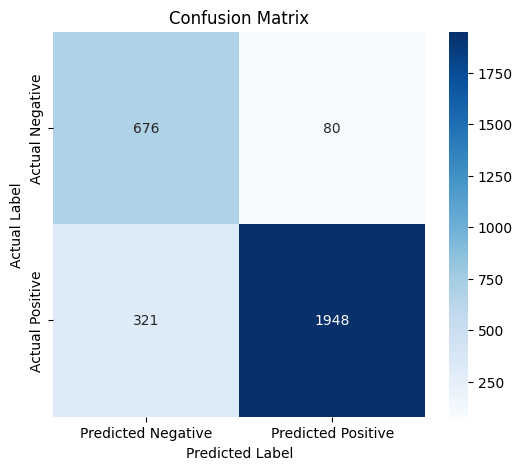

In [28]:
cm = confusion_matrix(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# **Explanation of Models Predictions in Terms of Real Objectives**

* The model correctly classifies 87% of the reviews, which indicates robust performance overall.

* For businesses focused on addressing customer dissatisfaction, the high recall (89%) for negative reviews ensures that most issues are flagged.

* On the other hand, high precision for positive reviews (96%) reinforces confidence in positive sentiment identification, which can be useful for marketing and customer satisfaction analysis.

# **Model Building: BiRNN**

# **Hyperparameter Tuning with Optuna & BiRNN with Early Stopping**

In [62]:
def objective(trial):
    # Suggest hyperparameters
    embedding_dim = trial.suggest_categorical('embedding_dim', [32, 64, 128, 256])
    rnn_units = trial.suggest_int('rnn_units', 16, 128, step=32)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Build the Bidirectional SimpleRNN model
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                        output_dim=embedding_dim,
                        input_length=maxlen))
    # Note: SimpleRNN supports dropout and recurrent_dropout in modern Keras versions
    model.add(Bidirectional(SimpleRNN(rnn_units, dropout=dropout_rate, recurrent_dropout=dropout_rate)))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

    # Train the model with a validation split and early stopping
    history = model.fit(X_train_padded, y_train,
                        epochs=20,
                        batch_size=batch_size,
                        validation_split=0.2,
                        callbacks=[early_stop],
                        class_weight=class_weights,
                        verbose=1)

    val_accuracy = history.history['val_accuracy'][-1]
    return val_accuracy

# Create and run the Optuna study (maximize validation accuracy)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10, n_jobs = 1)  # Adjust n_trials, n_jobs as needed

print("Best trial:")
trial = study.best_trial
print("  Best Validation Accuracy: {:.4f}".format(trial.value))
print("  Best Hyperparameters:")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-02-24 11:01:27,671] A new study created in memory with name: no-name-4db1007d-65ba-4330-a269-6b7fe38fcb06


213/303 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.5203 - loss: 0.6905Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.5293 - loss: 0.6896 - val_accuracy: 0.2628 - val_loss: 0.7682
Epoch 6/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.5137 - loss: 0.7174 - val_accuracy: 0.4826 - val_loss: 0.6957
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 103s 334ms/step - accuracy: 0.6820 - loss: 0.6070 - val_accuracy: 0.8248 - val_loss: 0.4117
Epoch 2/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.5618 - loss: 0.6813 - val_accuracy: 0.6868 - val_loss: 0.6800
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.9000 - loss: 0.2822 - val_accuracy: 0.8401 - val_loss: 0.4057
Epoch 3/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.5180 - loss: 0.7056 - val_accuracy: 0.7070 - val_loss: 0.6749
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
105/303 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.5026 - l

[I 2025-02-24 11:01:52,741] Trial 1 finished with value: 0.7070248126983643 and parameters: {'embedding_dim': 32, 'rnn_units': 48, 'dropout_rate': 0.4, 'learning_rate': 0.0004030161667604454, 'batch_size': 32}. Best is trial 1 with value: 0.7070248126983643.


76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9289 - loss: 0.2020 - val_accuracy: 0.8459 - val_loss: 0.3946
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.5277 - loss: 0.6954 - val_accuracy: 0.7372 - val_loss: 0.6391
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 31s 143ms/step - accuracy: 0.5023 - loss: 0.7653 - val_accuracy: 0.2653 - val_loss: 0.7578
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9426 - loss: 0.1672 - val_accuracy: 0.8281 - val_loss: 0.4481
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9515 - loss: 0.1383 - val_accuracy: 0.8475 - val_loss: 0.4585
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.5015 - loss: 0.7558 - val_accuracy: 0.2640 - val_loss: 0.7741
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9637 - loss: 0.1104 - val_accuracy: 0.8550 - val_loss: 0.4730
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


[I 2025-02-24 11:02:06,890] Trial 0 finished with value: 0.8549586534500122 and parameters: {'embedding_dim': 256, 'rnn_units': 16, 'dropout_rate': 0.1, 'learning_rate': 0.003654770824369776, 'batch_size': 128}. Best is trial 0 with value: 0.8549586534500122.


76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.4946 - loss: 0.7468 - val_accuracy: 0.2690 - val_loss: 0.7574
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.4900 - loss: 0.7475 - val_accuracy: 0.2789 - val_loss: 0.7364
272/303 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5799 - loss: 0.6757Epoch 5/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.5785 - loss: 0.6764 - val_accuracy: 0.7384 - val_loss: 0.6508
Epoch 9/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5019 - loss: 0.7165 - val_accuracy: 0.7050 - val_loss: 0.6687
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5042 - loss: 0.7321 - val_accuracy: 0.7326 - val_loss: 0.6426
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5202 - loss: 0.7263 - val_accuracy: 0.7326 - val_loss: 0.6478
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5184 - loss: 0.7186 - val_accuracy: 0.7339 - val_loss: 0.6478
Epoch 9/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 30m

[I 2025-02-24 11:02:29,112] Trial 0 finished with value: 0.734297513961792 and parameters: {'embedding_dim': 256, 'rnn_units': 48, 'dropout_rate': 0.5, 'learning_rate': 0.00021862482463161354, 'batch_size': 128}. Best is trial 0 with value: 0.734297513961792.


 49/303 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5929 - loss: 0.6724Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.5889 - loss: 0.6771 - val_accuracy: 0.7372 - val_loss: 0.6339
Epoch 10/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5981 - loss: 0.6821 - val_accuracy: 0.7550 - val_loss: 0.6631
Epoch 11/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - accuracy: 0.5307 - loss: 0.7442 - val_accuracy: 0.7029 - val_loss: 0.6581
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5060 - loss: 0.7214 - val_accuracy: 0.6711 - val_loss: 0.6757
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5147 - loss: 0.7229 - val_accuracy: 0.7178 - val_loss: 0.6745
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6272 - loss: 0.6671 - val_accuracy: 0.6364 - val_loss: 0.6750
Epoch 12/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5341 - loss: 0.7115 - val_accuracy: 0.7169 - val_loss: 0.6633
Epoch 4: early stopping

[I 2025-02-24 11:02:56,468] Trial 1 finished with value: 0.7169421315193176 and parameters: {'embedding_dim': 64, 'rnn_units': 16, 'dropout_rate': 0.4, 'learning_rate': 0.0008019878600588044, 'batch_size': 128}. Best is trial 0 with value: 0.734297513961792.


 73/303 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6131 - loss: 0.6585Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6193 - loss: 0.6598 - val_accuracy: 0.6550 - val_loss: 0.6612
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 9.
 7/76 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4983 - loss: 0.8243

[I 2025-02-24 11:03:05,110] Trial 1 finished with value: 0.6549586653709412 and parameters: {'embedding_dim': 128, 'rnn_units': 112, 'dropout_rate': 0.4, 'learning_rate': 0.0006151793465357972, 'batch_size': 32}. Best is trial 0 with value: 0.8623967170715332.


76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.5015 - loss: 0.7730 - val_accuracy: 0.2636 - val_loss: 0.7504
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4986 - loss: 0.7417 - val_accuracy: 0.2632 - val_loss: 0.7345
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5054 - loss: 0.7186 - val_accuracy: 0.7045 - val_loss: 0.6741
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5252 - loss: 0.7140 - val_accuracy: 0.7236 - val_loss: 0.6790
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5159 - loss: 0.7044 - val_accuracy: 0.7054 - val_loss: 0.6884
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5380 - loss: 0.6948 - val_accuracy: 0.7372 - val_loss: 0.6491
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5154 - loss: 0.6902 - val_accuracy: 0.7372 - val_loss: 0.6635
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5044 - loss: 0.7014 - val_accuracy: 0.7372 - val_loss: 0

[I 2025-02-24 11:03:29,595] Trial 2 finished with value: 0.42603304982185364 and parameters: {'embedding_dim': 32, 'rnn_units': 112, 'dropout_rate': 0.5, 'learning_rate': 0.001072536431075726, 'batch_size': 128}. Best is trial 0 with value: 0.734297513961792.


Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.7097 - loss: 0.5713 - val_accuracy: 0.8174 - val_loss: 0.4313
Epoch 2/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.8923 - loss: 0.2881 - val_accuracy: 0.8665 - val_loss: 0.3425
Epoch 3/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9322 - loss: 0.1932 - val_accuracy: 0.8612 - val_loss: 0.3709
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9480 - loss: 0.1524 - val_accuracy: 0.8657 - val_loss: 0.4082
Epoch 5/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9635 - loss: 0.1104 - val_accuracy: 0.8409 - val_loss: 0.4808
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


[I 2025-02-24 11:04:29,706] Trial 3 finished with value: 0.8409090638160706 and parameters: {'embedding_dim': 128, 'rnn_units': 48, 'dropout_rate': 0.1, 'learning_rate': 0.0014746638746043791, 'batch_size': 32}. Best is trial 3 with value: 0.8409090638160706.


Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.5330 - loss: 0.7654 - val_accuracy: 0.7372 - val_loss: 0.6122
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5375 - loss: 0.7712 - val_accuracy: 0.7364 - val_loss: 0.6164
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5377 - loss: 0.7461 - val_accuracy: 0.7360 - val_loss: 0.6242
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5350 - loss: 0.7580 - val_accuracy: 0.7355 - val_loss: 0.6247
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


[I 2025-02-24 11:04:48,689] Trial 4 finished with value: 0.7355371713638306 and parameters: {'embedding_dim': 32, 'rnn_units': 16, 'dropout_rate': 0.5, 'learning_rate': 0.00020566313837872563, 'batch_size': 128}. Best is trial 3 with value: 0.8409090638160706.


Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.4842 - loss: 0.7157 - val_accuracy: 0.6917 - val_loss: 0.6761
Epoch 2/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5169 - loss: 0.6993 - val_accuracy: 0.6983 - val_loss: 0.6752
Epoch 3/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.5308 - loss: 0.6925 - val_accuracy: 0.7198 - val_loss: 0.6676
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5521 - loss: 0.6970 - val_accuracy: 0.7120 - val_loss: 0.6722
Epoch 5/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5356 - loss: 0.6939 - val_accuracy: 0.7310 - val_loss: 0.6672
Epoch 6/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5455 - loss: 0.7010 - val_accuracy: 0.7322 - val_loss: 0.6640
Epoch 7/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5787 - loss: 0.6833 - val_accuracy: 0.7364 - val_loss: 0.6623
Epoch 8/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5809 - loss: 0.6727 - val

[I 2025-02-24 11:07:32,223] Trial 5 finished with value: 0.7797520756721497 and parameters: {'embedding_dim': 256, 'rnn_units': 16, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00010184221352067024, 'batch_size': 32}. Best is trial 3 with value: 0.8409090638160706.


Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.4895 - loss: 0.7700 - val_accuracy: 0.2632 - val_loss: 0.7737
Epoch 2/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.4947 - loss: 0.7443 - val_accuracy: 0.2636 - val_loss: 0.7359
Epoch 3/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5012 - loss: 0.7371 - val_accuracy: 0.3347 - val_loss: 0.7054
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.4957 - loss: 0.7303 - val_accuracy: 0.4855 - val_loss: 0.6955
Epoch 5/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5120 - loss: 0.7205 - val_accuracy: 0.5372 - val_loss: 0.6946
Epoch 6/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5085 - loss: 0.7193 - val_accuracy: 0.3223 - val_loss: 0.7079
Epoch 7/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.5239 - loss: 0.7103 - val_accuracy: 0.3302 - val_loss: 0.7040
Epoch 8/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5092 - loss: 0.7192 - val_

[I 2025-02-24 11:08:47,712] Trial 6 finished with value: 0.41033056378364563 and parameters: {'embedding_dim': 64, 'rnn_units': 112, 'dropout_rate': 0.5, 'learning_rate': 0.0002143313049795632, 'batch_size': 32}. Best is trial 3 with value: 0.8409090638160706.


Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.4865 - loss: 0.7228 - val_accuracy: 0.7045 - val_loss: 0.6600
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5218 - loss: 0.7046 - val_accuracy: 0.7492 - val_loss: 0.6548
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5711 - loss: 0.6795 - val_accuracy: 0.4620 - val_loss: 0.6934
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5863 - loss: 0.6574 - val_accuracy: 0.6884 - val_loss: 0.6554
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6493 - loss: 0.6247 - val_accuracy: 0.7946 - val_loss: 0.5788
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7399 - loss: 0.5748 - val_accuracy: 0.8116 - val_loss: 0.5147
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8369 - loss: 0.4695 - val_accuracy: 0.8227 - val_loss: 0.4083
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8674 - loss: 0.3771 - val_acc

[I 2025-02-24 11:09:51,164] Trial 7 finished with value: 0.8471074104309082 and parameters: {'embedding_dim': 64, 'rnn_units': 16, 'dropout_rate': 0.2, 'learning_rate': 0.0005639957231558616, 'batch_size': 64}. Best is trial 7 with value: 0.8471074104309082.


Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.5092 - loss: 0.7256 - val_accuracy: 0.7360 - val_loss: 0.6614
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5298 - loss: 0.7023 - val_accuracy: 0.2628 - val_loss: 0.8416
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5945 - loss: 0.6482 - val_accuracy: 0.7579 - val_loss: 0.5235
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7726 - loss: 0.5005 - val_accuracy: 0.7665 - val_loss: 0.5265
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8323 - loss: 0.3967 - val_accuracy: 0.7537 - val_loss: 0.5505
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8411 - loss: 0.3675 - val_accuracy: 0.7533 - val_loss: 0.5964
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


[I 2025-02-24 11:10:13,314] Trial 8 finished with value: 0.7533057928085327 and parameters: {'embedding_dim': 128, 'rnn_units': 80, 'dropout_rate': 0.4, 'learning_rate': 0.007598869681425638, 'batch_size': 128}. Best is trial 7 with value: 0.8471074104309082.


Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.7529 - loss: 0.5107 - val_accuracy: 0.8331 - val_loss: 0.4072
Epoch 2/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.8936 - loss: 0.2968 - val_accuracy: 0.8409 - val_loss: 0.3974
Epoch 3/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9045 - loss: 0.2622 - val_accuracy: 0.8405 - val_loss: 0.4352
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9130 - loss: 0.2245 - val_accuracy: 0.8331 - val_loss: 0.4509
Epoch 5/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9401 - loss: 0.1657 - val_accuracy: 0.8331 - val_loss: 0.4630
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


[I 2025-02-24 11:11:14,942] Trial 9 finished with value: 0.8330578804016113 and parameters: {'embedding_dim': 256, 'rnn_units': 16, 'dropout_rate': 0.1, 'learning_rate': 0.006530930932483476, 'batch_size': 32}. Best is trial 7 with value: 0.8471074104309082.


Best trial:
  Best Validation Accuracy: 0.8471
  Best Hyperparameters:
    embedding_dim: 64
    rnn_units: 16
    dropout_rate: 0.2
    learning_rate: 0.0005639957231558616
    batch_size: 64


# **Training the Final BiRNN Model with Best Hyperparameters and Early Stopping**

In [64]:
best_params = trial.params

final_model = Sequential()
final_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                          output_dim=best_params['embedding_dim'],
                          input_length=maxlen))
final_model.add(Bidirectional(SimpleRNN(best_params['rnn_units'],
                                        dropout=best_params['dropout_rate'],
                                        recurrent_dropout=best_params['dropout_rate'])))
final_model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
final_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

final_history = final_model.fit(X_train_padded, y_train,
                                epochs=20,
                                batch_size=best_params['batch_size'],
                                validation_split=0.2,
                                callbacks=[early_stop],
                                class_weight=class_weights,
                                verbose=1)

Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.4701 - loss: 0.7139 - val_accuracy: 0.3169 - val_loss: 0.7130
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5486 - loss: 0.6923 - val_accuracy: 0.6930 - val_loss: 0.6603
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6146 - loss: 0.6725 - val_accuracy: 0.7343 - val_loss: 0.6386
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6787 - loss: 0.6606 - val_accuracy: 0.7554 - val_loss: 0.6132
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7166 - loss: 0.6261 - val_accuracy: 0.7579 - val_loss: 0.5863
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7561 - loss: 0.5710 - val_accuracy: 0.7632 - val_loss: 0.5402
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8111 - loss: 0.5104 - val_accuracy: 0.7636 - val_loss: 0.5044
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8436 - loss: 0.4278 - val_acc

# **Plotting the Training & Validation Results**

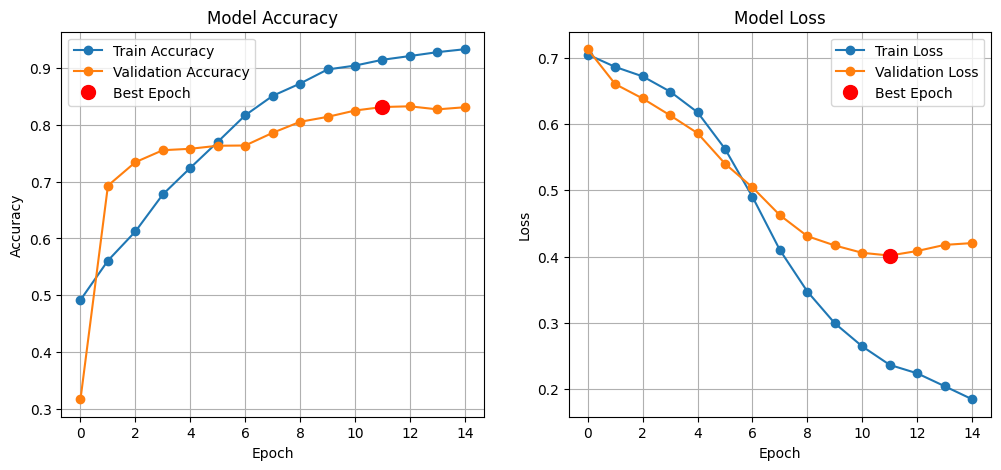

In [66]:
# Identifying the best epoch based on validation loss
best_epoch = np.argmin(final_history.history['val_loss']) + 1
best_epoch_idx = best_epoch - 1

# Plotting all training/validation curves
plt.figure(figsize=(12, 5))

# Accuracy Subplot
plt.subplot(1, 2, 1)
plt.plot(final_history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(final_history.history['val_accuracy'], marker='o', label='Validation Accuracy')

# Highlighting the best epoch in validation accuracy
best_val_acc = final_history.history['val_accuracy'][best_epoch_idx]
plt.plot(best_epoch_idx, best_val_acc, 'ro', markersize=10, label='Best Epoch')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Subplot
plt.subplot(1, 2, 2)
plt.plot(final_history.history['loss'], marker='o', label='Train Loss')
plt.plot(final_history.history['val_loss'], marker='o', label='Validation Loss')

# Highlighting the best epoch in validation loss
best_val_loss = final_history.history['val_loss'][best_epoch_idx]
plt.plot(best_epoch_idx, best_val_loss, 'ro', markersize=10, label='Best Epoch')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# **Saving the History Using Pickle**

In [67]:
with open('BiRNN_model_history.pkl', 'wb') as f:
    pickle.dump(final_history.history, f)

# **Evaluating the Final Model on the Test Set**

In [ ]:
test_loss, test_accuracy = final_model.evaluate(X_test_padded, y_test, verbose=1)
print("Test Accuracy: {:.4f}".format(test_accuracy))

# Predict test labels
y_pred_prob = final_model.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype("int32")

# **Plotting Confusion Matrix**

95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8265 - loss: 0.4164
Test Accuracy: 0.8383
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.80      0.71       756
           1       0.93      0.85      0.89      2269

    accuracy                           0.84      3025
   macro avg       0.78      0.83      0.80      3025
weighted avg       0.86      0.84      0.84      3025



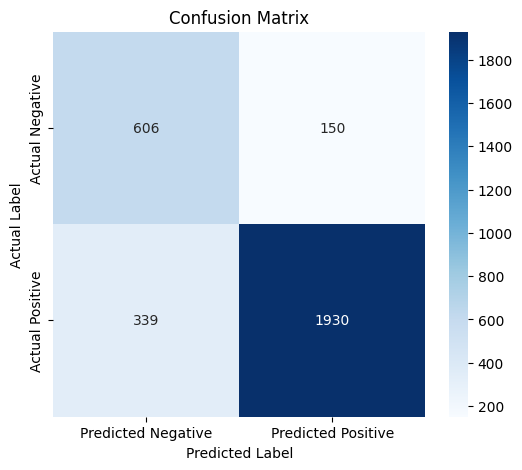

In [68]:
cm = confusion_matrix(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# **Explanation of Models Predictions in Terms of Real Objectives**

* The model achieved an overall test accuracy of about 84%, which means it correctly classifies 84% of the reviews. This is a decent performance for sentiment analysis.

* If our objective is to identify areas for improvement like catching negative reviews for remediation, the high recall (80%) for negatives is beneficial.

* For leveraging positive feedback (such as in promotions), the high precision (93%) for positive predictions ensures you can trust the positive sentiment tags most of the time.

# **Model Building: DistilBERT**

# **Applying Train-Test Split & Converting to Hugging Face Datasets**

In [72]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['score'])

# Converting Pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# **Performing the Tokenization**

In [73]:
# Loading the DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Defining a tokenization function
def tokenize_function(example):
    return tokenizer(example['content'], truncation=True, padding='max_length', max_length=128)

# Applying the tokenization to the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Renaming the label column to "labels" because Trainer API expects this
train_dataset = train_dataset.rename_column("score", "labels")
test_dataset = test_dataset.rename_column("score", "labels")

# Setting the format for PyTorch
columns_to_keep = ['input_ids', 'attention_mask', 'labels']
train_dataset.set_format(type='torch', columns=columns_to_keep)
test_dataset.set_format(type='torch', columns=columns_to_keep)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/12099 [00:00<?, ? examples/s]

Map:   0%|          | 0/3025 [00:00<?, ? examples/s]

# **Model Setup: DistilBERT for Sequence Classification**

In [74]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **Defining the Metrics for Evaluation**

In [75]:
def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

# **Training Arguments and Trainer Setup**

In [97]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to=[]
    )


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

# **Training the Model**

In [98]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.062400,0.465430,0.898512,0.939046,0.926362,0.932661
2,0.074700,0.485170,0.898512,0.940603,0.924619,0.932542
3,0.055400,0.556817,0.893884,0.936726,0.922440,0.929528


TrainOutput(global_step=1137, training_loss=0.06249503829338725, metrics={'train_runtime': 460.9742, 'train_samples_per_second': 131.233, 'train_steps_per_second': 4.111, 'total_flos': 1202042292254208.0, 'train_loss': 0.06249503829338725, 'epoch': 3.0})

# **Evaluating on the Test Set**

In [99]:
eval_metrics = trainer.evaluate()
print("Evaluation Metrics:", eval_metrics)

Evaluation Metrics: {'eval_loss': 0.4654304087162018, 'eval_accuracy': 0.8985123966942149, 'eval_precision': 0.9390459363957597, 'eval_recall': 0.9263616557734204, 'eval_f1': 0.9326606711998245, 'eval_runtime': 9.7302, 'eval_samples_per_second': 310.889, 'eval_steps_per_second': 9.763, 'epoch': 3.0}


# **Saving the DistilBERT History**

In [100]:
# Filter the log history to extract only evaluation logs that include eval_loss, eval_accuracy, and epoch
eval_logs = [log for log in trainer.state.log_history
             if 'eval_loss' in log and 'eval_accuracy' in log and 'epoch' in log]

# Save the filtered evaluation metrics to a JSON file
with open("eval_metrics.json", "w") as f:
    json.dump(eval_logs, f, indent=4)

# **Plotting the Evaluation Metrics with the Best Epoch**

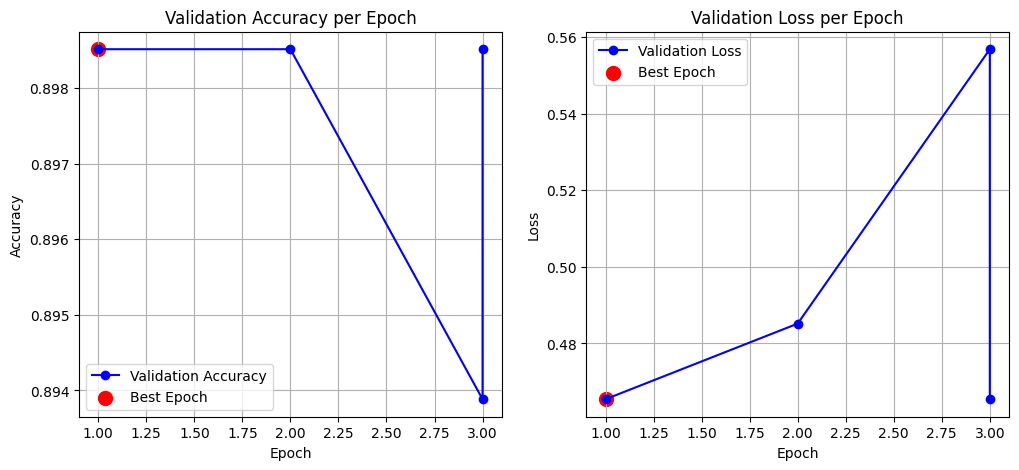

In [102]:
# We'll filter out the evaluation logs (which have 'eval_loss' and 'eval_accuracy')
log_history = trainer.state.log_history
eval_logs = [log for log in log_history if 'eval_loss' in log and 'epoch' in log]
# Sorting the logs by epoch
eval_logs = sorted(eval_logs, key=lambda x: x['epoch'])

# Extracting the epochs, evaluation loss, and evaluation accuracy.
epochs = [log['epoch'] for log in eval_logs]
eval_loss = [log['eval_loss'] for log in eval_logs]
eval_accuracy = [log['eval_accuracy'] for log in eval_logs]

# Determining the best epoch based on evaluation accuracy
best_idx = np.argmax(eval_accuracy)
best_epoch = epochs[best_idx]


plt.figure(figsize=(12, 5))

# Validation Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_accuracy, marker='o', label='Validation Accuracy', color='blue')
plt.scatter([best_epoch], [eval_accuracy[best_idx]], color='red', s=100, label='Best Epoch')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Validation Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, eval_loss, marker='o', label='Validation Loss', color='blue')
plt.scatter([best_epoch], [eval_loss[best_idx]], color='red', s=100, label='Best Epoch')
plt.title('Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

# **Generating the Confusion Matrix and Classification Report**

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       730
           1       0.94      0.93      0.93      2295

    accuracy                           0.90      3025
   macro avg       0.86      0.87      0.86      3025
weighted avg       0.90      0.90      0.90      3025



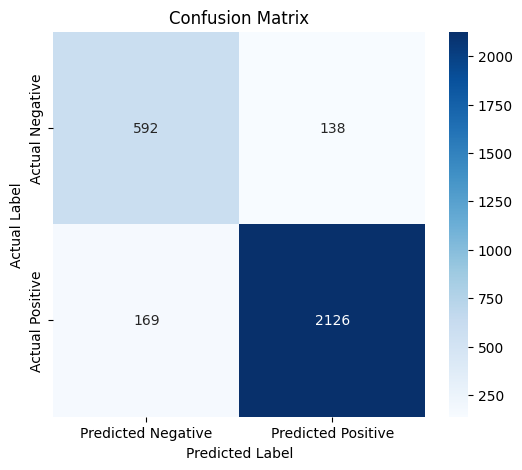

In [103]:
# Using the trained trainer to predict on the test dataset
predictions_output = trainer.predict(test_dataset)
predictions = np.argmax(predictions_output.predictions, axis=1)
true_labels = predictions_output.label_ids

# Computing the confusion matrix and classification report
cm = confusion_matrix(true_labels, predictions)
print("Classification Report:")
print(classification_report(true_labels, predictions))

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# **Explanation of Models Predictions in Terms of Real Objectives**

* The model correctly classifies 90% of the reviews, meaning it's generally reliable in distinguishing between negative and positive feedback.

* The transformer model performs well in a practical setting—effectively flagging negative reviews for prompt attention while reliably confirming positive reviews. This balance is crucial for real-world sentiment analysis where both capturing user issues and leveraging positive feedback are key objectives.

# **All 3 Models Performance Comparison**

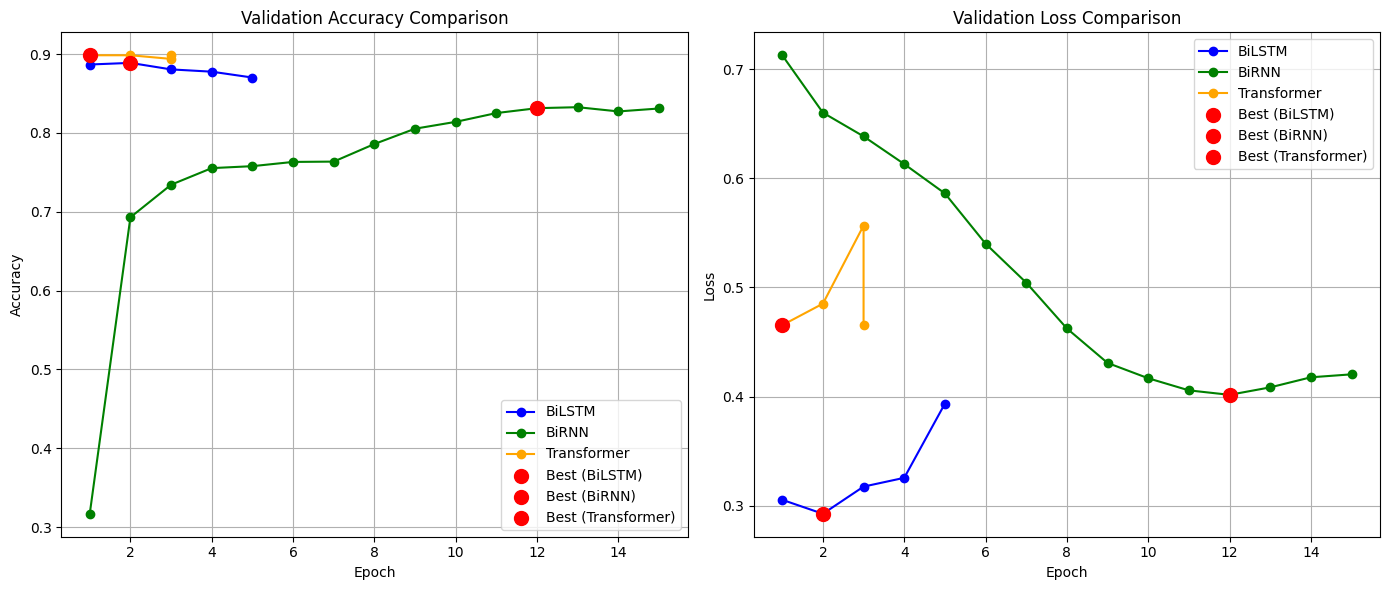

In [24]:
# Loading the BiLSTM history
with open('/content/BiLSTM_model_history.pkl', 'rb') as f:
    bilstm_history = pickle.load(f)

# Loading the BiRNN history
with open('/content/BiRNN_model_history.pkl', 'rb') as f:
    birnn_history = pickle.load(f)

# Loading the transformer evaluation logs
with open('/content/eval_metrics.json', 'r') as f:
    transformer_logs = json.load(f)

# Filtering the logs to ensure they have the necessary keys
transformer_logs = [log for log in transformer_logs if 'eval_loss' in log and 'eval_accuracy' in log and 'epoch' in log]
# Sort by epoch
transformer_logs = sorted(transformer_logs, key=lambda x: x['epoch'])

# For BiLSTM and BiRNN, create epoch arrays
bilstm_val_acc = bilstm_history['val_accuracy']
bilstm_val_loss = bilstm_history['val_loss']
epochs_bilstm = np.arange(1, len(bilstm_val_acc) + 1)

birnn_val_acc = birnn_history['val_accuracy']
birnn_val_loss = birnn_history['val_loss']
epochs_birnn = np.arange(1, len(birnn_val_acc) + 1)

# For Transformer, extract epochs, accuracy and loss from logs.
transformer_epochs = [log['epoch'] for log in transformer_logs]
transformer_val_acc = [log['eval_accuracy'] for log in transformer_logs]
transformer_val_loss = [log['eval_loss'] for log in transformer_logs]

# 3. Defining the Best Epochs as per the Previous Plots
bilstm_best_epoch = 1 + 1
birnn_best_epoch   = 11 + 1
transformer_best_epoch = 1

# Getting the best metrics for highlighting:
bilstm_best_acc = bilstm_val_acc[bilstm_best_epoch - 1]
bilstm_best_loss = bilstm_val_loss[bilstm_best_epoch - 1]

birnn_best_acc = birnn_val_acc[birnn_best_epoch - 1]
birnn_best_loss = birnn_val_loss[birnn_best_epoch - 1]

# For transformer, finding the log corresponding to the best epoch
transformer_best_acc = next(log['eval_accuracy'] for log in transformer_logs if log['epoch'] == transformer_best_epoch)
transformer_best_loss = next(log['eval_loss'] for log in transformer_logs if log['epoch'] == transformer_best_epoch)


plt.figure(figsize=(14, 6))

# Plotting the Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_bilstm, bilstm_val_acc, marker='o', label='BiLSTM', color='blue')
plt.plot(epochs_birnn, birnn_val_acc, marker='o', label='BiRNN', color='green')
plt.plot(transformer_epochs, transformer_val_acc, marker='o', label='Transformer', color='orange')

# Highlighting the best epochs with a larger red marker
plt.scatter(bilstm_best_epoch, bilstm_best_acc, color='red', s=100, zorder=5, label='Best (BiLSTM)')
plt.scatter(birnn_best_epoch, birnn_best_acc, color='red', s=100, zorder=5, label='Best (BiRNN)')
plt.scatter(transformer_best_epoch, transformer_best_acc, color='red', s=100, zorder=5, label='Best (Transformer)')

plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plotting the Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_bilstm, bilstm_val_loss, marker='o', label='BiLSTM', color='blue')
plt.plot(epochs_birnn, birnn_val_loss, marker='o', label='BiRNN', color='green')
plt.plot(transformer_epochs, transformer_val_loss, marker='o', label='Transformer', color='orange')

# Highlighting the best epochs with a larger red marker
plt.scatter(bilstm_best_epoch, bilstm_best_loss, color='red', s=100, zorder=5, label='Best (BiLSTM)')
plt.scatter(birnn_best_epoch, birnn_best_loss, color='red', s=100, zorder=5, label='Best (BiRNN)')
plt.scatter(transformer_best_epoch, transformer_best_loss, color='red', s=100, zorder=5, label='Best (Transformer)')

plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# **Conclusion**

* While all three models are competent, the transformer-based DistilBERT model outperforms the RNN-based models in overall accuracy and balance between classes. Its strong performance in both precision and recall makes it the best choice when aiming for reliable sentiment classification, despite the potentially higher computational cost.